## 3 Policy Function Iteration

$$
f^\prime(k) = (Ak^\alpha + p(1-\delta)k)^\prime = \alpha Ak^{\alpha - 1} + p(1-\delta)
$$
$$
U^\prime(c) = (\frac{c^{1-\sigma}}{1-\sigma})^\prime = c^{-\sigma} \Rightarrow U^\prime(f(k) - g(k)) = (Ak^\alpha + p(1-\delta)k - pk^\prime)^{-\sigma}
$$

In [8]:
f_prime(x) = α * A * x^(α - 1) + p * (1 - δ)
F_prime(x, y) = (f(x) - (p * y)) > 0 ? ((f(x) - (p * y))^(-σ)) : 0;

In [9]:
function Bellman_Solver(θ, F, F_prime, f, f_prime, tol)
    A, α, δ, p, σ, β, N = θ
    N = Int64(N)

    Γ(k) = min(A * k^α / p + (1-δ) * k, K_max)

    #𝑖
    ρ = 1 / β - 1
    K_star = ((A * α) / (p * (ρ + δ))) ^ (1 / (1 - α))

    #𝑖𝑖
    K_min = 0.95*K_star
    K_max = K_star
    K_grid = collect(range(0.0, K_max, length = N))

    #𝑖𝑖𝑖
    g = [zeros(N)] #Initial Guess
    dist = 1
    K_prime = zeros(N)
    V_prime = zeros(N)
    
    #𝑖𝑣
    while dist > tol
        for i ∈ 1:N
            y = g[end][i]
            x = K_grid[i]
            V_prime[i] = F_prime(x, y) * f_prime(x)
        end
        V_prime2 = LinearInterpolation(K_grid, V_prime)
        for i ∈ 1:N
            x = K_grid[i]
            G(z) = (F_prime(x, z) - β * V_prime2(z))^2
            K_prime[i] = optimize(G, 0.0, Γ(x)).minimizer
        end

        dist = maximum(abs.(K_prime .- g[end]))
        append!(g, [K_prime])
        K_prime = zeros(N)
        V_prime = zeros(N)
    end
    
    I = [g[end][i] - (1 - δ) * K_grid[i] for i ∈ 1:N]
    C = [A * g[end][i]^α - p * (K_prime[i] - (1 - δ) * K_grid[i]) for i ∈ 1:N]
    return g, LinearInterpolation(K_grid, g[end]), K_grid, LinearInterpolation(K_grid, C), LinearInterpolation(K_grid, I)
end

Bellman_Solver (generic function with 2 methods)

In [10]:
g, K′, K, C, I = Bellman_Solver(θ, F, F_prime, f, f_prime, 10^-7);

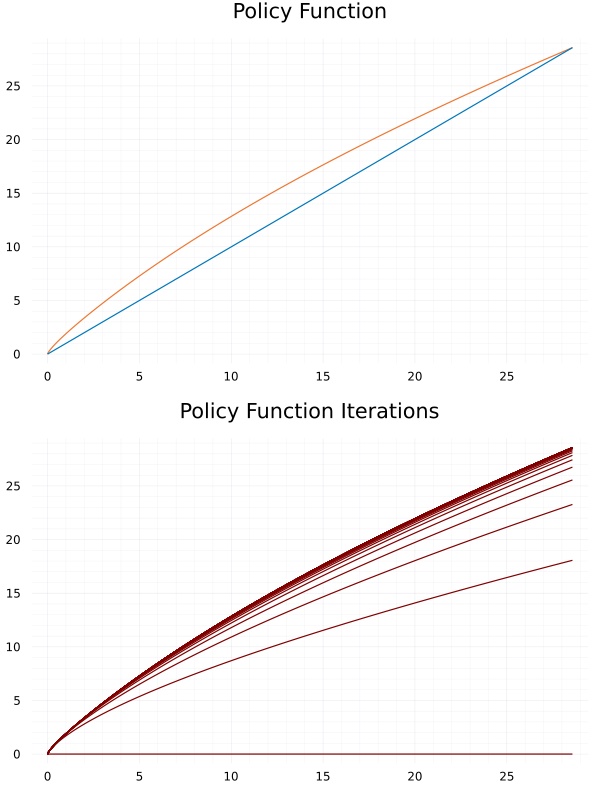

In [11]:
kk(x) = K′(x)
p1 = plot(kk, K, legend = false, title = "Policy Function")
p1 = plot!(K, K)
p2 = plot(K, g, legend = false, color = "maroon", title = "Policy Function Iterations")
plot(p1, p2, layout = (2, 1), size = (600, 800), dpi = 1000)

### Constructing TimeSeries 

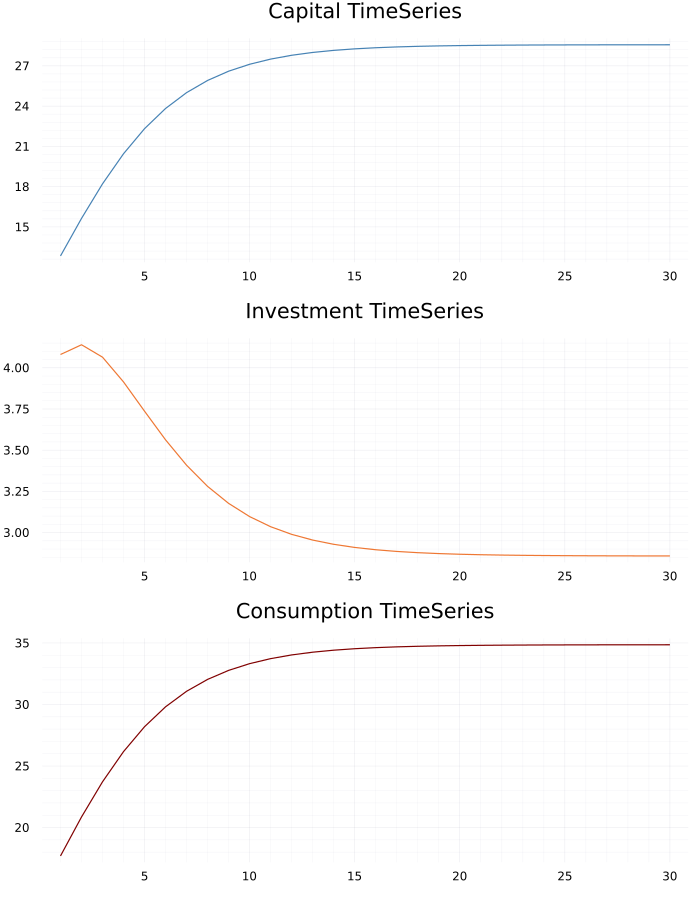

In [12]:
function to_timeseries(k₀, T; K = K′, I = missing, C = missing)
    k(T) = T == 1 ? K(k₀) : K(k(T-1))
    result = [k(i) for i ∈ 1:T]
    if !ismissing(I)
        result = I.(result)
    elseif !ismissing(C)
        result = C.(result)
    end
    return result
end

#Capital TimeSeries
Capital = to_timeseries(10, 30, K = K′)
p1 = plot(Capital, title = "Capital TimeSeries", color = "steelblue", legend = false)

#Investment TimeSeries
Investment = to_timeseries(10, 30, I = I)
p2 = plot(Investment, title = "Investment TimeSeries", legend = false)

#Consumption TimeSeries
Consumption = to_timeseries(10, 30, C = C)
p3 = plot(Consumption, title = "Consumption TimeSeries", color = "maroon", legend = false)

plot(p1, p2, p3, layout = (3, 1), size = (700, 900), dpi = 1000)